In [1]:
%cd ~/programs/critic-llm/
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

is_dark = False
theme, cs = rp.mpl_setup(is_dark)

/home/nicholas/programs/critic-llm


In [2]:
from critic import load_llama_corrector
from critic.simple_corrector import UniformCorrector
corrector = load_llama_corrector(n_threads=2, new_kbd=True, kbd_weight=1)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
llama_new_context_with_model: n_ctx_per_seq (256) < n_ctx_train (131072) -- the full capacity of the model will not be utilized


In [3]:
just_lm = load_llama_corrector()
just_lm.base = UniformCorrector()

llama_new_context_with_model: n_ctx_per_seq (256) < n_ctx_train (131072) -- the full capacity of the model will not be utilized


In [4]:
df = pd.read_feather('precomputed/all_typos.feather')
print(df.shape)
df.head()

(35551, 12)


,kind,corrected,participant,weight,p,t,ist,i,j,context,wrong_char,right_char
0,omission,False,469,1.0,Can you help get this cleared up?,Can you help get th¬s cleared up?,Can you help get th␣s cleared up?,19,NaN,Can you help get this,s,i
1,substitute,True,469,1.0,Can you help get this cleared up?,Can you help get th¬s cleared up?,Can you help get th␣s cleared up?,20,19.0,Can you help get this c,␣,s
2,omission,False,469,1.0,Doctors gave him 10 years ␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years¬␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years␣ t liv␈␈␈␈␈␈to live ...,25,NaN,Doctors gave him 10 years to,t,
3,insertion,True,469,1.0,Doctors gave him 10 years ␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years¬␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years␣ t liv␈␈␈␈␈␈to live ...,25,NaN,Doctors gave him 10 years to,␣,t
4,insertion,True,469,1.0,Doctors gave him 10 years ␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years¬␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years␣ t liv␈␈␈␈␈␈to live ...,26,NaN,Doctors gave him 10 years to,,t


In [5]:
last = df.groupby('p').last().reset_index()
prompts = last['p']
text = last['t']

def clean(series):
    return series.str.replace('␣', '').str.replace('¬', '')

last['p_clean'] = clean(prompts)
last['t_clean'] = clean(text)


clean = last[last['p_clean'].str.lower() != last['t_clean'].str.lower()][['p_clean', 't_clean']]

valid = clean[clean['p_clean'].str.count(' ') == clean['t_clean'].str.count(' ')]
valid[valid['p_clean'].str.contains('could be')]

/tmp/ipykernel_2553251/959341736.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  last = df.groupby('p').last().reset_index()


,p_clean,t_clean
3935,"If the Penskes have any luck at all, they coul...","If the Penskes have any luck as all, they coul..."
3939,"If the Penskes have any luck at all, they coul...","If the Penskes have any luck at all, tey could..."
3941,"If we don't get it, could be trouble.","If we don't get it, could be trouble"
3945,"If we don't get it, could be trouble.","If we do't get it, could be trouble."
3947,"If we don't get it, could be trouble.","If we dont get it, could be trouble."


In [6]:
import pickle
from dataclasses import dataclass
from time import perf_counter
from tqdm import tqdm
from string import ascii_lowercase

from critic.corrector import Corrections
from critic.kbd_layout import QWERTY
from critic.simple_corrector import SimpleCorrector, UniformCorrector

@dataclass
class CorrectionResult:
    true: str
    typed: str
    corrs: Corrections
    context: str
    time: float


def evaluate(corrector, path):
    results = []
    data = valid[1::10]
    for i, row in tqdm(data.iterrows(), total=data.shape[0]):
        corrector.clear_context()
        context = ''

        p_words = row['p_clean'].split(' ')
        t_words = row['t_clean'].split(' ')

        for true, typed in zip(p_words, t_words):
            if all(c.lower() in ascii_lowercase for c in true + typed):
                start = perf_counter()
                corrs = corrector.correct(typed)
                end = perf_counter()
                results.append(CorrectionResult(true, typed, corrs, context, end - start))

            corrector.push_word(true)
            context += true + ' '

    print(len(results))

    with open(f'results/{path}.pkl', 'wb') as f:
        pickle.dump(results, f)

    return results


# opt_results = evaluate(corrector, 'optimized_probs')
# kbd_results = evaluate(corrector.base, 'kbd_probs')
# lm_results = evaluate(just_lm, 'lm_probs')
# corrector.base.model = old_mod
# evaluate(corrector, 'old_probs')

# simple = SimpleCorrector()
# simple_results = evaluate(simple, 'simple_probs')

In [7]:
from typing import Sequence


def grade(res: CorrectionResult):
    corrs = res.corrs.as_series().sort_values(ascending=False)
    if res.true in corrs.index:
        data = {
            'prob': corrs[res.true],
            'rank': list(corrs.index).index(res.true) + 1
        }
    else:
        data = {
            'prob': 0,
            'rank': np.nan
        }

    data['error'] = res.true != res.typed
    data['correct'] = res.true == corrs.index[0]
    data['time'] = res.time

    return data

def grade_all(results: Sequence[CorrectionResult]):
    return pd.DataFrame([grade(res) for res in results])

# res_df = grade_all(opt_results)
# display(res_df.mean().round(3))
# res_df

In [8]:
grade_dfs = []

for path, name in [    
    ('optimized_probs', 'LM + Keyboard'),
    ('kbd_probs', 'Keyboard Only'),
    ('lm_probs', 'LM Only')
]:
    with open(f'results/{path}.pkl', 'rb') as f:
        results = pickle.load(f)
        grades = grade_all(results)
        grades['model'] = name
        grade_dfs.append(grades)

grades = pd.concat(grade_dfs, axis=0).reset_index(names='i')
grades['in_list'] = ~pd.isna(grades['rank'])

display(pd.crosstab(grades.query('model == "LM + Keyboard"')['error'], grades.query('model == "LM + Keyboard"')['correct']))

display(grades.groupby('model').mean().round(3)[['prob', 'rank', 'correct', 'time']])
# display(grades.query('error').groupby('model').mean().round(2)[['prob', 'rank', 'correct']])

# with sns.plotting_context('talk'):
#     g = sns.displot(grades, x='prob', row='model', aspect=2)
#     g.set_titles('{row_name}')
#     for ax in g.axes.flatten():
#         rp.ylabel_top(ax=ax)

#     g = sns.displot(grades, x='rank', discrete=True, row='model')
#     for ax in g.axes.flatten():
#         rp.ylabel_top(ax=ax)

correct,False,True
error,,
False,18,2158
True,200,127


,prob,rank,correct,time
model,,,,
Keyboard Only,0.819,1.520,0.883,0.078
LM + Keyboard,0.905,1.263,0.913,0.345
LM Only,0.743,1.547,0.805,0.264


In [9]:
# thread_df = grades.query('model == "LM + Keyboard"').copy().drop(columns=['model'])
# thread_df['cores'] = 2
# res_df['cores'] = 1

# thread_df = pd.concat([thread_df, res_df])
# thread_df

# thread_df.groupby('cores').agg({'time': lambda x: np.mean(x > 0.8)}) * 100

# sns.boxplot(thread_df, x='time', hue='cores', palette='tab10')
# plt.suptitle('Seconds Per Word')

# critic = grades.query('model == "LM + Keyboard"')
# pd.crosstab(critic['error'], critic['correct'])

In [10]:
grades.query('in_list and error').groupby('model').mean().drop(columns=['i', 'in_list']).round(3)

,prob,rank,error,correct,time
model,,,,,
Keyboard Only,0.161,5.929,1.0,0.187,0.081
LM + Keyboard,0.509,3.440,1.0,0.504,0.399
LM Only,0.752,1.480,1.0,0.786,0.315


In [11]:
grades.pivot(index='i', columns='model', values='correct').query('not `Keyboard Only` and not `LM Only` and `LM + Keyboard`')

model,Keyboard Only,LM + Keyboard,LM Only
i,,,
33,False,True,False
253,False,True,False
1237,False,True,False
1474,False,True,False
1684,False,True,False
2373,False,True,False
2422,False,True,False


In [12]:
with open('results/kbd_probs.pkl' , 'rb') as f:
    kbd = pickle.load(f)

with open('results/lm_probs.pkl' , 'rb') as f:
    lm = pickle.load(f)

len(kbd), len(lm)

(2503, 2503)

In [13]:
kbd[253].corrs.as_series().sort_values(ascending=False)

Comfirmed      5.151269e-01
Confirmed      4.736504e-01
Com firmed     5.452475e-03
Com-firmed     5.452475e-03
Confirm        2.237272e-04
Comforted      9.353834e-05
Comforter      4.874742e-07
Comedic        9.915158e-10
Comfortless    1.059379e-10
Discomfited    3.015923e-25
dtype: float64

In [14]:
lm[253].corrs.as_series().sort_values(ascending=False)

Confirm        9.011164e-01
Confirmed      6.405732e-02
Comforter      2.651422e-02
Comforted      7.899933e-03
Comfortless    3.655558e-04
Comedic        4.659565e-05
Comfirmed      9.083786e-09
Com firmed     2.770686e-09
Discomfited    4.579917e-10
Com-firmed     9.860619e-11
dtype: float64

In [15]:
from scipy.special import logit, softmax
from scipy.optimize import minimize_scalar

@np.vectorize
def objective(lm_w):    
    probs = []
    for r1, r2 in zip(kbd, lm):
        s1 = r1.corrs.as_series()
        s2 = r2.corrs.as_series().loc[s1.index]

        s3 = lm_w * logit(s1) + (1 - lm_w) * logit(s2)
        s3.iloc[:] = softmax(s3)
        probs.append(s3.to_dict().get(r1.true, 0))
    return np.mean(probs)

ww = np.linspace(0.1, 0.9, 7)
oo = objective(ww)

/home/nicholas/anaconda3/envs/critic/lib/python3.11/site-packages/scipy/special/_logsumexp.py:234: RuntimeWarning: invalid value encountered in subtract
  exp_x_shifted = np.exp(x - x_max)


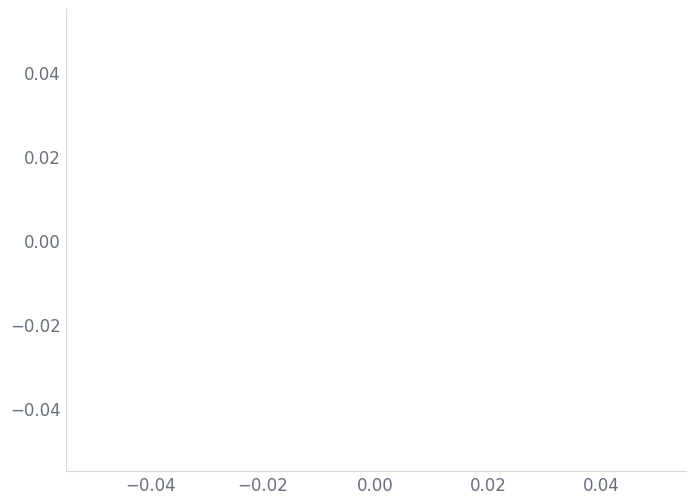

In [16]:
plt.plot(ww, oo)

llama_new_context_with_model: n_ctx_per_seq (256) < n_ctx_train (131072) -- the full capacity of the model will not be utilized
llama_new_context_with_model: n_ctx_per_seq (256) < n_ctx_train (131072) -- the full capacity of the model will not be utilized


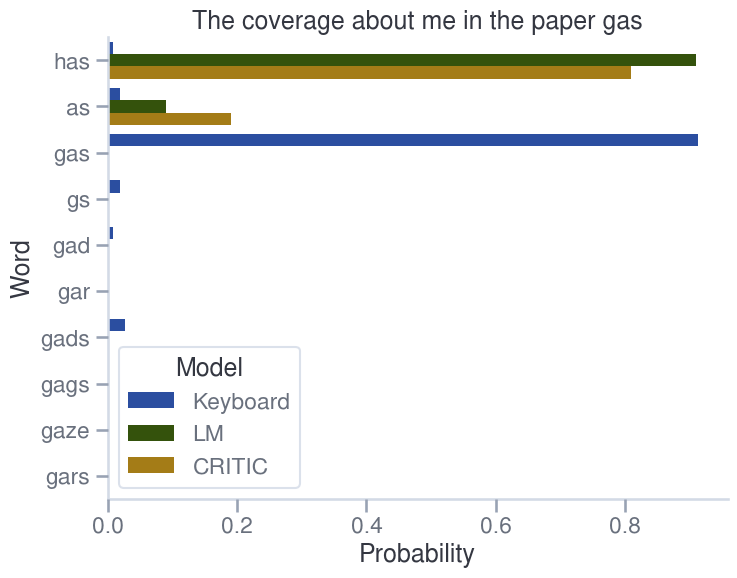

In [23]:
from copy import deepcopy


corrector = load_llama_corrector()


kbd_corrector = corrector.base
lm_corrector = load_llama_corrector()
lm_corrector.base = UniformCorrector()


# context = ''
# word = 'Thr'
context = 'The coverage about me in the paper'
word = 'gas'


corrector.push_words(context)
lm_corrector.push_words(context)

corrs = corrector.correct(word).as_series()
kbd_corrs = kbd_corrector.correct(word).as_series()
lm_corrs = lm_corrector.correct(word).as_series()


df = pd.DataFrame({'Keyboard': kbd_corrs, 'LM': lm_corrs, 'CRITIC': corrs}).reset_index(names='Word').sort_values('CRITIC', ascending=False).iloc[:10].melt(var_name='Model', value_name='Probability', id_vars=['Word'])

plt.rcParams['font.sans-serif'] = 'Nimbus Sans'
with sns.plotting_context('talk'):    
    sns.barplot(df, x='Probability', y='Word', orient='h', hue='Model')
    plt.gca().set_title(f'{context} {word}')

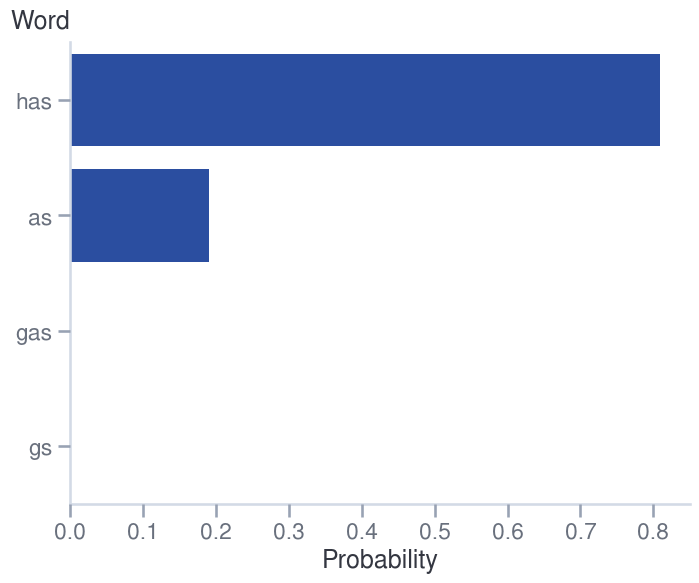

In [28]:
with sns.plotting_context('talk'):
    sns.barplot(df.query('Model == "CRITIC"').sort_values('Probability', ascending=False).iloc[:4], x='Probability', y='Word', orient='h',)
    rp.ylabel_top()

In [18]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))